### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [47]:
import pandas as pd

## 0 - Getting the Data

In [2]:
!wget -O data.csv "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"

--2023-10-05 12:42:14--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data.csv’

100%[======================================>] 1,475,504   --.-K/s   in 0.007s  

2023-10-05 12:42:14 (209 MB/s) - ‘data.csv’ saved [1475504/1475504]



In [48]:
df=pd.read_csv('data.csv')

## 1 - Cleaning the Data

In [49]:
# Keep only the columns above
features=[
    'Make',
    'Model',
    'Year',
    'Engine HP',
    'Engine Cylinders',
    'Transmission Type',
    'Vehicle Style',
    'highway MPG',
    'city mpg',
    'MSRP'
]

In [50]:
df_hw = df[features]

In [51]:
#Lowercase the column names and replace spaces with underscores
df_hw.columns = df_hw.columns.str.lower().str.replace(" ","_")

In [52]:
categorical = df_hw.select_dtypes(include='object').columns

In [53]:
#Lowercase the values and replace spaces with underscores
for c in categorical:
      df_hw[c] = df_hw[c].str.lower().str.replace(" ","_")

/tmp/ipykernel_19390/1601938297.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_hw[c] = df_hw[c].str.lower().str.replace(" ","_")


In [54]:
#Fill the missing values with 0
df_hw = df_hw.fillna(0)

In [55]:
# Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable above_average
above_average = (df_hw.msrp > df_hw.msrp.mean())
above_average = above_average.astype(int)
df_hw['above_average'] = above_average

In [56]:
from sklearn.model_selection import train_test_split

In [98]:
#Getting the full train and test
df_full_train, df_test = train_test_split(df_hw, test_size=0.2, random_state=1)

In [58]:
df_full_train = df_full_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [59]:
#Getting the train and val
df_train, df_val = train_test_split(df_full_train, test_size=0.2, random_state=1)

In [60]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

## Question 1: ROC AUC feature importance
- For each numerical variable, use it as score and compute AUC with the above_average variable
- Use the training dataset for that


In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [62]:
y_train = df_train.above_average.values

In [63]:
df_train.drop(columns=['above_average'])

,make,model,year,engine_hp,engine_cylinders,transmission_type,vehicle_style,highway_mpg,city_mpg,msrp
0,lexus,nx_200t,2015,235.0,4.0,automatic,4dr_suv,28,21,37980
1,ford,focus_st,2016,252.0,4.0,manual,4dr_hatchback,31,22,24425
2,toyota,sienna,2015,266.0,6.0,automatic,passenger_minivan,25,18,37445
3,mazda,mx-5_miata,2015,167.0,4.0,manual,convertible,28,21,26905
4,infiniti,g37_coupe,2010,330.0,6.0,automatic,coupe,27,19,36050
...,...,...,...,...,...,...,...,...,...,...
7619,subaru,impreza,2015,148.0,4.0,manual,4dr_hatchback,33,24,20995
7620,infiniti,qx50,2016,325.0,6.0,automatic,4dr_suv,24,17,35850
7621,honda,fit,2017,130.0,4.0,automatic,4dr_hatchback,37,32,20265
7622,audi,200,1991,162.0,5.0,automatic,sedan,20,16,2000


In [64]:
X_train = df_train.values

In [65]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [66]:
#Computing the AUC for each numerical variable
from sklearn.metrics import roc_auc_score

In [67]:
#engine_hp = 0.9162324220917971
#engine_cylinders = 0.7674408924408924
#highway_mpg = 0.6351930621461872
#city_mpg = 0.6754616043678544
roc_auc_score(df_train['above_average'].values, -df_train['city_mpg'].values)
#R = engine_hp

0.6754616043678544

## Question 2: Training the model

In [68]:
#I'm using Logistic Regression because it is a problem of binary classification (above_average)
clf = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000)
y_val = df_val.above_average.values
#Before fitting and predicting, I need to do some encoding.
#Getting numerical and categorical columns:
numerical = df_hw.select_dtypes(exclude=['object']).columns
categorical = df_hw.select_dtypes(include=['object']).columns
#Removing target columns from lists
categorical=list(categorical)
numerical=list(numerical)
numerical.remove('msrp')
numerical.remove('above_average')
#Applying the DictVectorizer
from sklearn.feature_extraction import DictVectorizer
train_dicts = df_train[categorical+numerical].to_dict(orient='records')
val_dicts = df_val[categorical+numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [69]:
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [70]:
y_val

array([1, 0, 0, ..., 0, 0, 0])

In [71]:
#What's the AUC of this model on the validation dataset? (round to 3 digits)
round(roc_auc_score(y_val, clf.predict(X_val)),3)
#R = 0.918 -> 0.878 is the closest

0.918

## Question 3: Precision and Recall

    Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
    For each threshold, compute precision and recall
    Plot them


In [72]:
y_pred = clf.predict_proba(X_val)[:,1]
y_pred

array([0.70874492, 0.00817255, 0.31478835, ..., 0.00818831, 0.01919113,
       0.15180179])

In [73]:
import numpy as np

In [74]:
def precision_recall_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        
        scores.append ((t, tp, fp, fn, tn))
        
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

    return df_scores

In [75]:
df_scores = precision_recall_dataframe(y_val, y_pred)

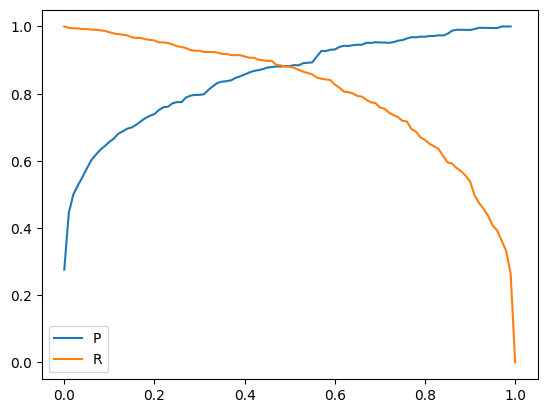

In [76]:
import matplotlib.pyplot as plt

plt.plot(df_scores.threshold, df_scores['p'], label = 'P')
plt.plot(df_scores.threshold, df_scores['r'], label = 'R')
plt.legend()
#R = 0.48

## Question 4: F1 Score
Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

In [77]:
def f1_dataframe(y_val, y_pred):
    scores = []
    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        
        p = tp  / (tp+fp)
        r = tp / (tp+fn)
        
        scores.append ((t, tp, fp, fn, tn, p, r))
        
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'p', 'r']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['f1'] = 2*(  (df_scores.p * df_scores.r)  / (df_scores.p + df_scores.r)    )

    return df_scores

In [78]:
df_scores = f1_dataframe(y_val, y_pred)

/tmp/ipykernel_19390/1127499493.py:18: RuntimeWarning: invalid value encountered in scalar divide
  p = tp  / (tp+fp)


In [79]:
print(df_scores['f1'][32], df_scores['threshold'][32])

0.8642413487133983 0.32


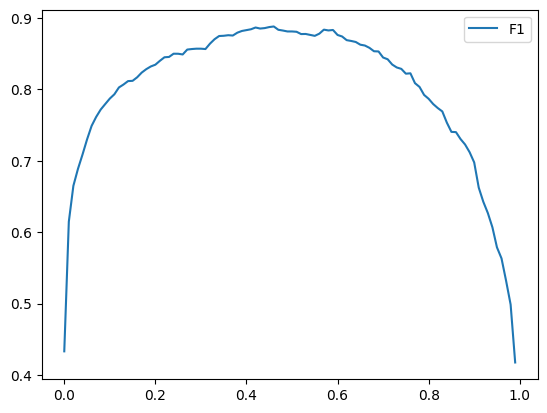

In [80]:
plt.plot(df_scores.threshold, df_scores['f1'], label = 'F1')
plt.legend()
#R = 0.46, which is closest to 0.52

## Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

In [81]:
from sklearn.model_selection import KFold

In [109]:
from tqdm.auto import tqdm

In [120]:
def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=True)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [121]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [122]:
#R: 0.003
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.above_average.values
    y_val = df_val.above_average.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
    print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.978 +- 0.000
0.980 +- 0.002
0.981 +- 0.002
0.981 +- 0.002
0.982 +- 0.003


## Question 6: Hyperparameter Tuning

In [127]:
def train(df_train, y_train, C=1):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=True)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [128]:
#R: C=10
for C in tqdm([0.01, 0.1, 0.5, 10]):
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.above_average.values
        y_val = df_val.above_average.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.952 +- 0.002
C=0.1 0.972 +- 0.002
C=0.5 0.979 +- 0.003
C=10 0.981 +- 0.002
